# $$Contents$$
* [1. Feature Engeneering]((#$$Feature Engeneering$$)
* [2. Preprocessing]((#$$Preprocessing$$)
* [3. Modelling]((#$$Modelling$$)
* [4. Submit]((#$$Submit$$)

In [16]:
!pip install catboost
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

from catboost import CatBoostClassifier, Pool, metrics, cv
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

import pandas as pd

  Using cached graphviz-0.19.1-py3-none-any.whl (46 kB)


# $$Feature Engeneering$$

In [67]:
data = pd.read_csv('C:/Users/user/Desktop/Pump_it_Up/Data_processed_new_coords.csv', index_col=0)

In [68]:
data

,gps_height,longitude,latitude,region_code,district_code,population,construction_year,labels,amount_tsh_bool,month_recorded,...,water_quality_encoded,quality_group_encoded,quantity_encoded,basin_encoded,region_encoded,lga_encoded,ward_encoded,extraction_type_encoded,source_encoded,waterpoint_type_encoded
0,1390.0,34.938093,-9.856322,11,5,109.0,1999.0,True,False,3,...,7,2,1,1,3,51,1429,3,8,1
1,1399.0,34.698766,-2.147466,20,2,280.0,2010.0,True,True,3,...,7,2,2,4,9,103,1581,3,5,1
2,686.0,37.460664,-3.821329,21,4,250.0,2009.0,True,False,2,...,7,2,1,5,8,108,1629,3,0,2
3,263.0,38.486161,-11.155298,90,63,58.0,1986.0,True,True,1,...,7,2,0,7,12,87,1576,14,3,2
4,1328.8,31.130847,-1.825359,18,1,264.0,2005.4,True,True,7,...,7,2,4,4,4,26,1692,3,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14845,34.0,38.852669,-6.582841,6,1,20.0,1988.0,False,True,2,...,7,2,1,8,14,3,2087,7,6,1
14846,1178.4,37.451633,-5.350428,4,7,2960.0,1994.0,False,False,3,...,5,5,2,5,20,33,1454,8,7,4
14847,1476.0,34.739804,-4.585587,13,2,200.0,2010.0,False,True,3,...,7,2,2,0,18,109,2000,3,0,1
14848,998.0,35.432732,-10.584159,10,2,150.0,2009.0,False,True,2,...,7,2,2,1,16,111,1072,3,6,1


In [71]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74250 entries, 0 to 14849
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   gps_height                 74250 non-null  float64
 1   longitude                  74250 non-null  float64
 2   latitude                   74250 non-null  float64
 3   region_code                74250 non-null  int64  
 4   district_code              74250 non-null  int64  
 5   population                 74250 non-null  float64
 6   construction_year          74250 non-null  float64
 7   labels                     74250 non-null  bool   
 8   amount_tsh_bool            74250 non-null  bool   
 9   month_recorded             74250 non-null  int64  
 10  funder_encoded             74250 non-null  int64  
 11  installer_encoded          74250 non-null  int64  
 12  scheme_management_encoded  74250 non-null  int64  
 13  scheme_name_encoded        74250 non-null  int

In [82]:
data_labels = pd.read_csv('C:/Users/user/Desktop/Pump_it_Up/y_train.csv', index_col=0)

In [83]:
data_labels

,status_group
id,
69572,functional
8776,functional
34310,functional
67743,non functional
19728,functional
...,...
60739,functional
27263,functional
37057,functional


In [84]:
data.drop('scheme_management_encoded', axis=1, inplace=True)

In [85]:
####################################################
# Частотное заполнение, где пороговое значения - 27.
####################################################
list1 = ['longitude', 'latitude']


for atribute in data.columns:

  condition_1 = len(data[atribute].unique()) > 27
  condition_2 = atribute not in list1             # не оправдало надежд...
  condition  = condition_1 & condition_2

  if condition_1:
    freq_enc = data[atribute].value_counts(normalize=True)
    data[atribute] = data[atribute].map(freq_enc)


In [86]:
# теперь кол-во уникальных значений сократилось
for atribute in data.columns:
  space = '                         '
  nou = len(data[atribute].unique())
  print(f'Кол-во уник. знач. для {atribute}{space[len(atribute):]}:', nou)

Кол-во уник. знач. для gps_height               : 131
Кол-во уник. знач. для longitude                : 19
Кол-во уник. знач. для latitude                 : 19
Кол-во уник. знач. для region_code              : 27
Кол-во уник. знач. для district_code            : 20
Кол-во уник. знач. для population               : 185
Кол-во уник. знач. для construction_year        : 138
Кол-во уник. знач. для labels                   : 2
Кол-во уник. знач. для amount_tsh_bool          : 2
Кол-во уник. знач. для month_recorded           : 12
Кол-во уник. знач. для funder_encoded           : 177
Кол-во уник. знач. для installer_encoded        : 175
Кол-во уник. знач. для scheme_name_encoded      : 189
Кол-во уник. знач. для public_meeting_encoded   : 2
Кол-во уник. знач. для permit_encoded           : 2
Кол-во уник. знач. для subvillage_encoded       : 112
Кол-во уник. знач. для wpt_name_encoded         : 99
Кол-во уник. знач. для management_encoded       : 11
Кол-во уник. знач. для payment_encoded     

In [88]:
data

,gps_height,longitude,latitude,region_code,district_code,population,construction_year,labels,amount_tsh_bool,month_recorded,...,water_quality_encoded,quality_group_encoded,quantity_encoded,basin_encoded,region_encoded,lga_encoded,ward_encoded,extraction_type_encoded,source_encoded,waterpoint_type_encoded
0,0.000539,0.000013,0.000013,11,5,0.000296,0.018316,True,False,3,...,7,2,1,1,3,0.009253,0.000552,3,8,1
1,0.000525,0.000013,0.000013,20,2,0.001859,0.044714,True,True,3,...,7,2,2,4,9,0.012189,0.001212,3,5,1
2,0.000148,0.000013,0.000013,21,4,0.028135,0.043152,True,False,2,...,7,2,1,5,8,0.005010,0.000175,3,0,2
3,0.000458,0.000013,0.000013,90,63,0.000418,0.023556,True,True,1,...,7,2,0,7,12,0.002869,0.000552,14,3,2
4,0.006747,0.000013,0.000013,18,1,0.006909,0.013953,True,True,7,...,7,2,4,4,4,0.013024,0.000189,3,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14845,0.000431,0.000013,0.000013,6,1,0.007515,0.012458,False,True,2,...,7,2,1,8,14,0.017010,0.001818,7,6,1
14846,0.001024,0.000013,0.000013,4,7,0.000013,0.013212,False,False,3,...,5,5,2,5,20,0.002842,0.000579,8,7,4
14847,0.000539,0.000013,0.000013,13,2,0.032108,0.044714,False,True,3,...,7,2,2,0,18,0.016189,0.000646,3,0,1
14848,0.000256,0.000013,0.000013,10,2,0.031380,0.043152,False,True,2,...,7,2,2,1,16,0.011798,0.002141,3,6,1


In [89]:
# Заменяем болевые значение атрибута amount_tsh_bool на 0 и 1
data['amount_tsh_bool'] = data.amount_tsh_bool.astype(int)

In [90]:
train = data[data.labels==True]
test = data[data.labels==False]
y = data_labels.status_group

In [91]:
train.drop('labels', axis=1, inplace=True)
test.drop('labels', axis=1, inplace=True)

C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [92]:
train

,gps_height,longitude,latitude,region_code,district_code,population,construction_year,amount_tsh_bool,month_recorded,funder_encoded,...,water_quality_encoded,quality_group_encoded,quantity_encoded,basin_encoded,region_encoded,lga_encoded,ward_encoded,extraction_type_encoded,source_encoded,waterpoint_type_encoded
0,0.000539,0.000013,0.000013,11,5,0.000296,0.018316,0,3,0.004552,...,7,2,1,1,3,0.009253,0.000552,3,8,1
1,0.000525,0.000013,0.000013,20,2,0.001859,0.044714,1,3,0.000862,...,7,2,2,4,9,0.012189,0.001212,3,5,1
2,0.000148,0.000013,0.000013,21,4,0.028135,0.043152,0,2,0.000121,...,7,2,1,5,8,0.005010,0.000175,3,0,2
3,0.000458,0.000013,0.000013,90,63,0.000418,0.023556,1,1,0.020364,...,7,2,0,7,12,0.002869,0.000552,14,3,2
4,0.006747,0.000013,0.000013,18,1,0.006909,0.013953,1,7,0.000013,...,7,2,4,4,4,0.013024,0.000189,3,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,0.000471,0.000013,0.000013,3,5,0.002020,0.018316,0,5,0.010303,...,7,2,1,5,6,0.010505,0.002020,3,8,1
59396,0.000458,0.000013,0.000013,11,4,0.002343,0.017522,0,5,0.000418,...,7,2,1,6,3,0.042128,0.000889,3,6,1
59397,0.001616,0.000013,0.000013,12,7,0.006343,0.026721,1,4,0.170074,...,1,1,1,6,10,0.010519,0.001481,15,3,4
59398,0.002007,0.000013,0.000013,1,4,0.001886,0.016741,1,3,0.000067,...,7,2,2,6,2,0.005912,0.000458,8,7,4


# $$Preprocessing$$

In [93]:
# stratify=True - сбалансированно делит нашу выборку т.е. в x_train и в x_test
# functional, non functional, functional needs repair будут в одинаковых пропорциях

x_train, x_test, y_train, y_test = train_test_split(train, y, 
                                                    test_size=0.3,
                                                    stratify=y.values)

In [94]:
x_train

,gps_height,longitude,latitude,region_code,district_code,population,construction_year,amount_tsh_bool,month_recorded,funder_encoded,...,water_quality_encoded,quality_group_encoded,quantity_encoded,basin_encoded,region_encoded,lga_encoded,ward_encoded,extraction_type_encoded,source_encoded,waterpoint_type_encoded
8485,0.008741,0.000013,0.000013,14,1,0.008269,0.034370,1,2,0.022182,...,7,2,1,0,19,0.009832,0.000498,8,7,4
695,0.014290,0.000013,0.000013,20,2,0.000512,0.042074,1,2,0.014195,...,7,2,2,4,9,0.012189,0.001562,8,7,4
31879,0.000081,0.000013,0.000013,11,3,0.045226,0.042074,1,2,0.024229,...,7,2,1,1,3,0.010626,0.001953,3,8,1
7365,0.000013,0.000013,0.000013,11,3,0.045226,0.044714,1,3,0.004552,...,7,2,1,1,3,0.010626,0.000997,3,8,1
32607,0.000485,0.000013,0.000013,5,2,0.032108,0.017724,1,2,0.014343,...,5,5,2,8,11,0.008835,0.000700,15,7,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58949,0.000269,0.000013,0.000013,11,1,0.122801,0.015286,0,3,0.055488,...,7,2,1,6,3,0.012310,0.000822,3,8,1
57372,0.000377,0.000013,0.000013,20,2,0.009374,0.034370,1,2,0.000013,...,5,5,2,4,9,0.012189,0.000862,0,7,4
45853,0.000552,0.000013,0.000013,2,7,0.000781,0.021051,1,3,0.000485,...,7,2,2,5,0,0.016754,0.000768,3,8,1
14549,0.000512,0.000081,0.000081,19,6,0.000108,0.000471,1,8,0.015313,...,7,2,2,3,13,0.008121,0.000418,9,5,1


In [99]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41580 entries, 8485 to 7652
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   gps_height               41580 non-null  float64
 1   longitude                41580 non-null  float64
 2   latitude                 41580 non-null  float64
 3   region_code              41580 non-null  int64  
 4   district_code            41580 non-null  int64  
 5   population               41580 non-null  float64
 6   construction_year        41580 non-null  float64
 7   amount_tsh_bool          41580 non-null  int32  
 8   month_recorded           41580 non-null  int64  
 9   funder_encoded           41580 non-null  float64
 10  installer_encoded        41580 non-null  float64
 11  scheme_name_encoded      41580 non-null  float64
 12  public_meeting_encoded   41580 non-null  int64  
 13  permit_encoded           41580 non-null  int64  
 14  subvillage_encoded  

In [127]:
list_ignor = []
for i, atribute in enumerate(x_train.columns):
  space = '                         '
  nou = len(data[atribute].unique())
  print(f'{i} /Кол-во уник. знач. для {atribute}{space[len(atribute):]}:', nou)
  if nou > 10:
        list_ignor.append(i) 

0 /Кол-во уник. знач. для gps_height               : 131
1 /Кол-во уник. знач. для longitude                : 19
2 /Кол-во уник. знач. для latitude                 : 19
3 /Кол-во уник. знач. для region_code              : 27
4 /Кол-во уник. знач. для district_code            : 20
5 /Кол-во уник. знач. для population               : 185
6 /Кол-во уник. знач. для construction_year        : 138
7 /Кол-во уник. знач. для amount_tsh_bool          : 2
8 /Кол-во уник. знач. для month_recorded           : 12
9 /Кол-во уник. знач. для funder_encoded           : 177
10 /Кол-во уник. знач. для installer_encoded        : 175
11 /Кол-во уник. знач. для scheme_name_encoded      : 189
12 /Кол-во уник. знач. для public_meeting_encoded   : 2
13 /Кол-во уник. знач. для permit_encoded           : 2
14 /Кол-во уник. знач. для subvillage_encoded       : 112
15 /Кол-во уник. знач. для wpt_name_encoded         : 99
16 /Кол-во уник. знач. для management_encoded       : 11
17 /Кол-во уник. знач. для payment_en

In [128]:
############################################################################
# Получили список индексов колонок, где число уникальных значений больше 10.
############################################################################

list_ignor

[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 14, 15, 16, 23, 24, 25, 26]

In [287]:
# Список индексов атрибутов, где значение НЕ float
categorical_features_indices = np.where(x_train.dtypes != float)[0]
print(categorical_features_indices)

[ 3  4  7  8 12 13 16 17 18 19 20 21 22 23 26 27 28]


In [157]:
# Список индексов атрибутов, где значение НЕ float и не более 10 уникальных значений
categorical_features_indices = set(categorical_features_indices) - set(list_ignor)
categorical_features_indices = np.array(list(categorical_features_indices))
print(categorical_features_indices)

# $$Modelling$$

In [160]:
###################
# Создаем CAtBoost.
###################

model3 = CatBoostClassifier(
    custom_loss=[metrics.Accuracy()],
    random_seed=42,
    logging_level='Silent',
    iterations=5000
)

In [ ]:
###################################
# Обучение CAtBoost классификатора.
###################################

model3.fit(
    x_train, y_train,
    cat_features=categorical_features_indices,
    eval_set=(x_test, y_test),
#    logging_level='Verbose',
    plot=True,
    use_best_model=True
);

In [292]:
model3.save_model('C:/Users/user/Desktop/Pump_it_Up/CatBoost_model_3', format='cbm')

In [288]:
predict3 = model3.predict(x_test)

 $$\ Проведем\ сравнение\ моделей\ по\ основным\ метрикам\ качества$$

In [289]:
print(classification_report(y_test, predict3))

                         precision    recall  f1-score   support

             functional       0.78      0.89      0.83      9678
functional needs repair       0.59      0.27      0.37      1295
         non functional       0.83      0.75      0.79      6847

               accuracy                           0.79     17820
              macro avg       0.73      0.64      0.66     17820
           weighted avg       0.79      0.79      0.78     17820



In [ ]:
predict1 = model1.predict(x_test)

In [255]:
print(classification_report(y_test, predict1))

                         precision    recall  f1-score   support

             functional       0.78      0.90      0.84      9678
functional needs repair       0.63      0.26      0.37      1295
         non functional       0.83      0.75      0.79      6847

               accuracy                           0.80     17820
              macro avg       0.75      0.64      0.67     17820
           weighted avg       0.79      0.80      0.78     17820



In [302]:
'''
ЗАМЕТКА:
Модель "model1" обучена ниже

'''
print()

In [117]:
###################
# Создаем CAtBoost.
###################

model1 = CatBoostClassifier(
    custom_loss=[metrics.Accuracy()],
    random_seed=42,
    logging_level='Silent',
    iterations=1500,
)

In [ ]:
###################################
# Обучение CAtBoost классификатора.
###################################

model1.fit(
    x_train, y_train,
#    cat_features=categorical_features_indices,
    eval_set=(x_test, y_test),
#    logging_level='Verbose', 
    plot=True,
    use_best_model=True
);

In [299]:
model1.save_model('C:/Users/user/Desktop/Pump_it_Up/CatBoost_model_1', format='cbm')

In [275]:
###################
# Создаем CAtBoost.
###################

model_final = CatBoostClassifier(
    custom_loss=[metrics.Accuracy()],
    random_seed=42,
    logging_level='Silent',
    iterations=10000,
)

In [ ]:
###################################
# Обучение CAtBoost классификатора.
###################################

model_final.fit(
    train, y,
#    cat_features=categorical_features_indices,
#    logging_level='Verbose',  
    plot=True,
    use_best_model=True,
);

In [300]:
model_final.save_model('C:/Users/user/Desktop/Pump_it_Up/CatBoost_model_final', format='cbm')

In [277]:
predict_final = model_final.predict(x_test)

 $$\ Проведем\ сравнение\ моделей\ по\ основным\ метрикам\ качества$$

In [278]:
print(classification_report(y_test, predict_final))

                         precision    recall  f1-score   support

             functional       0.83      0.94      0.88      9678
functional needs repair       0.80      0.37      0.51      1295
         non functional       0.89      0.81      0.85      6847

               accuracy                           0.85     17820
              macro avg       0.84      0.71      0.75     17820
           weighted avg       0.85      0.85      0.84     17820



In [249]:
print(classification_report(y_test, predict_1))

                         precision    recall  f1-score   support

             functional       0.78      0.90      0.84      9678
functional needs repair       0.63      0.26      0.37      1295
         non functional       0.83      0.75      0.79      6847

               accuracy                           0.80     17820
              macro avg       0.75      0.64      0.67     17820
           weighted avg       0.79      0.80      0.78     17820



# $$Submit$$

In [216]:
test.shape

(14850, 29)

In [279]:
predict_final = model_final.predict(test)

In [280]:
predict_final.shape

(14850, 1)

In [281]:
submit_form = pd.read_csv('C:/Users/user/Desktop/Pump_it_Up/SubmissionFormat.csv')

In [282]:
submit_form['status_group'] = predict_final


In [283]:
submit_form

,id,status_group
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional
...,...,...
14845,39307,non functional
14846,18990,functional
14847,28749,functional
14848,33492,functional


In [285]:
submit_form.to_csv('C:/Users/user/Desktop/Pump_it_Up/Submit_9_CatBoost_10000.csv', index=False)

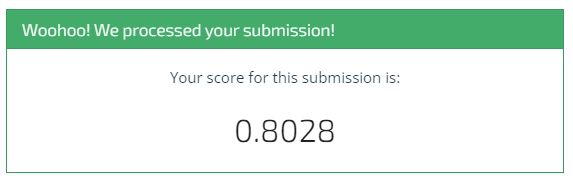

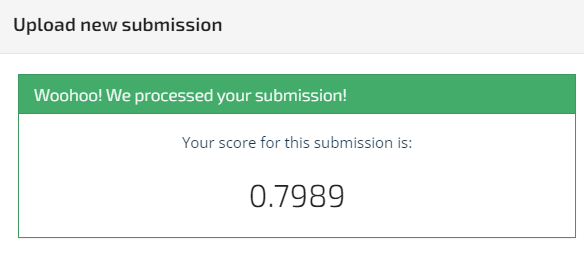

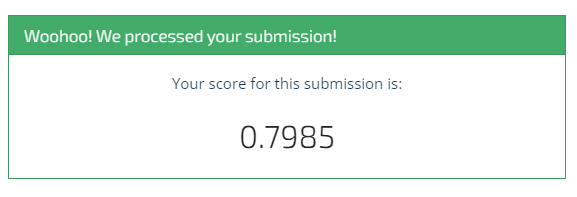